In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pqm import pqm_chi2, pqm_pvalue
from scipy.stats import norm, chi2, uniform

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
# Set font to Computer 
# mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rc("text", usetex=True)

Create a distribution, and sample from it twice

In [3]:
class GaussianMixtureModel:
    def __init__(self,num_components, num_dims, means=None, variances=None, weights=None):
        self.means = means if means is not None else np.random.randn(num_components, num_dims)
        self.variances = variances if variances is not None else np.random.rand(num_components, num_dims)
        self.weights = weights if weights is not None else np.ones(num_components)
        
        self.weights /= np.sum(self.weights)
        
        self.num_components = num_components
        self.num_dims = num_dims
        
    def generate_samples(self, num_samples):
        # Generate samples from each component
        samples = []
        samples_per_component = np.random.multinomial(num_samples, self.weights/np.sum(self.weights))
        for i in range(self.num_components):
            samples.append(np.random.multivariate_normal(self.means[i], np.diag(self.variances[i]), samples_per_component[i]))

        # Concatenate the samples from all components
        samples = np.concatenate(samples, axis=0)

        # Shuffle the samples
        np.random.shuffle(samples)

        return samples
    
    def get_means(self):
        return self.means
    
    def get_variances(self):
        return self.variances
    
    def get_weights(self):
        return self.weights

gmm = GaussianMixtureModel(num_components=20, num_dims=100)
x_samples = gmm.generate_samples(num_samples=10000)
y_samples = gmm.generate_samples(num_samples=10000)


We can repeat the experiment multiple times. The PQM statistic should follow a chi_squared distribution, with n_R - 2 degrees of freedom

In [4]:
zs = []
dof_array = []
num_repeats = 200
for num in range(num_repeats):
    x_samples = gmm.generate_samples(num_samples=5000)
    y_samples = gmm.generate_samples(num_samples=5000)
    z, dof = pqm_chi2(x_samples, y_samples)
    zs.append(z)
    dof_array.append(dof)

print(np.unique(dof_array), np.mean(zs), np.std(zs))

[95 97 98 99] 97.96371451032947 13.030385685989208


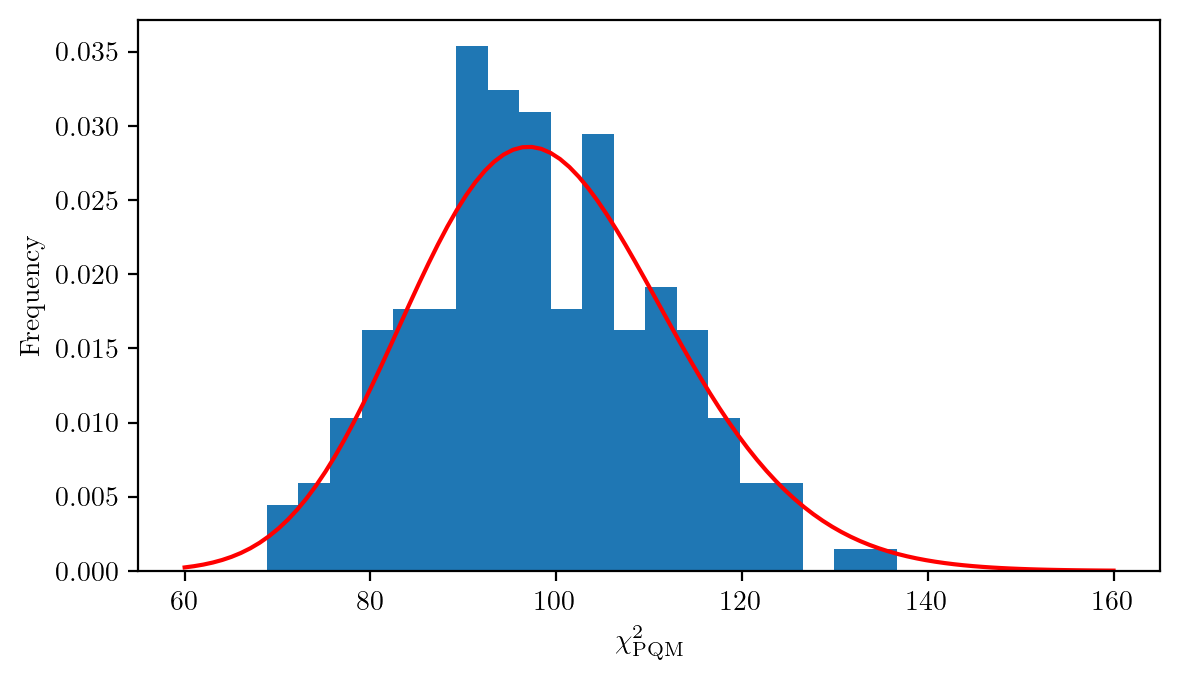

In [5]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.hist(zs, bins=20, density=True)
ax.plot(np.linspace(60, 160, 100), chi2.pdf(np.linspace(60, 160, 100), df=99), color='red')
ax.set_xlabel(r'$\chi^2_{{\rm PQM}}$')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [30]:
zs_mean = []
zs_std = []

gmm = GaussianMixtureModel(num_components=20, num_dims=100)


means = gmm.get_means()
variances = gmm.get_variances()
weights = gmm.get_weights()

for n_modes in range(10):
    gmm_short = GaussianMixtureModel(num_components=20 - n_modes, num_dims=100, means=means[n_modes:], variances=variances[n_modes:], weights=weights[n_modes:])
    zs = []
    dof_array = []
    x_samples = gmm.generate_samples(num_samples=5000)
    y_samples = gmm_short.generate_samples(num_samples=5000)
    for i in range(20):
        z, dof = pqm_chi2(x_samples, y_samples)
        zs.append(z)
        dof_array.append(dof)
    zs_mean.append(np.mean(zs))
    zs_std.append(np.std(zs))

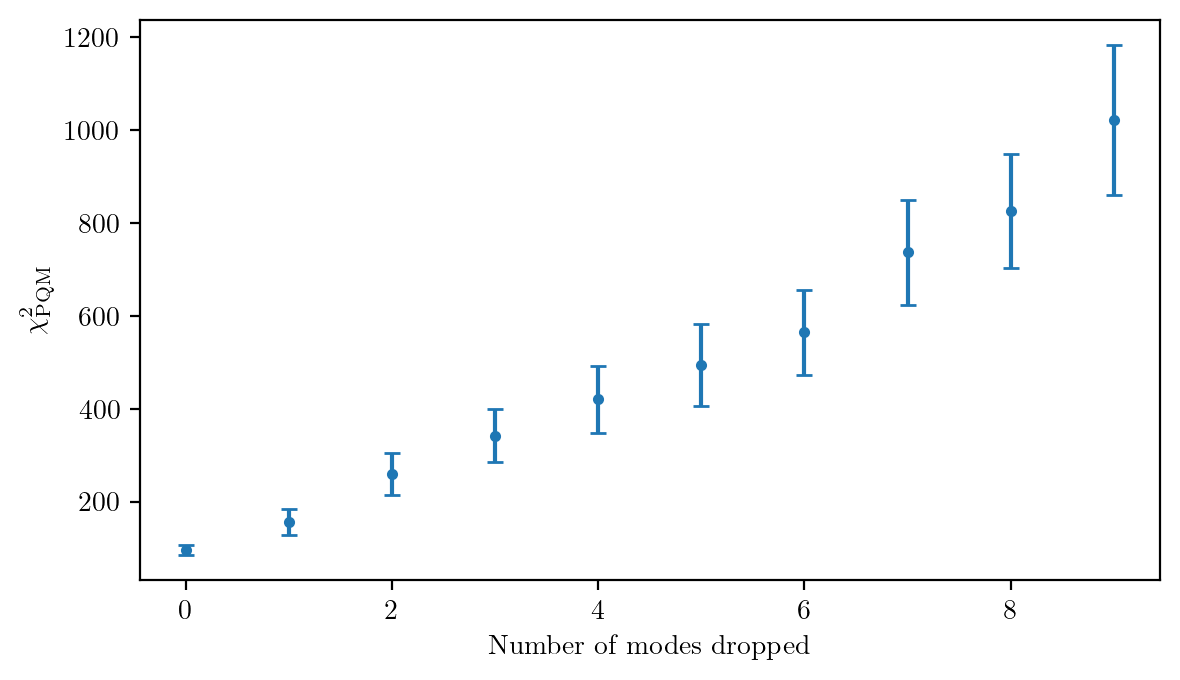

In [31]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.errorbar(np.arange(10), zs_mean, yerr=zs_std, fmt='.', capsize=3)
ax.set_xlabel(r'Number of modes dropped')
ax.set_ylabel(r'$\chi^2_{{\rm PQM}}$')
plt.tight_layout()
plt.show()

# Using p-value

In [51]:
p_val = []
num_repeats = 200
for _ in range(num_repeats):
    x_samples = gmm.generate_samples(num_samples=5000)
    y_samples = gmm.generate_samples(num_samples=5000)
    pval = pqm_pvalue(x_samples, y_samples)
    p_val.append(pval)

In [52]:
if np.mean(p_val) > 0.01:
    print("Do not reject the null hypothesis")
else:
    print("Reject the null hypothesis")


Do not reject the null hypothesis


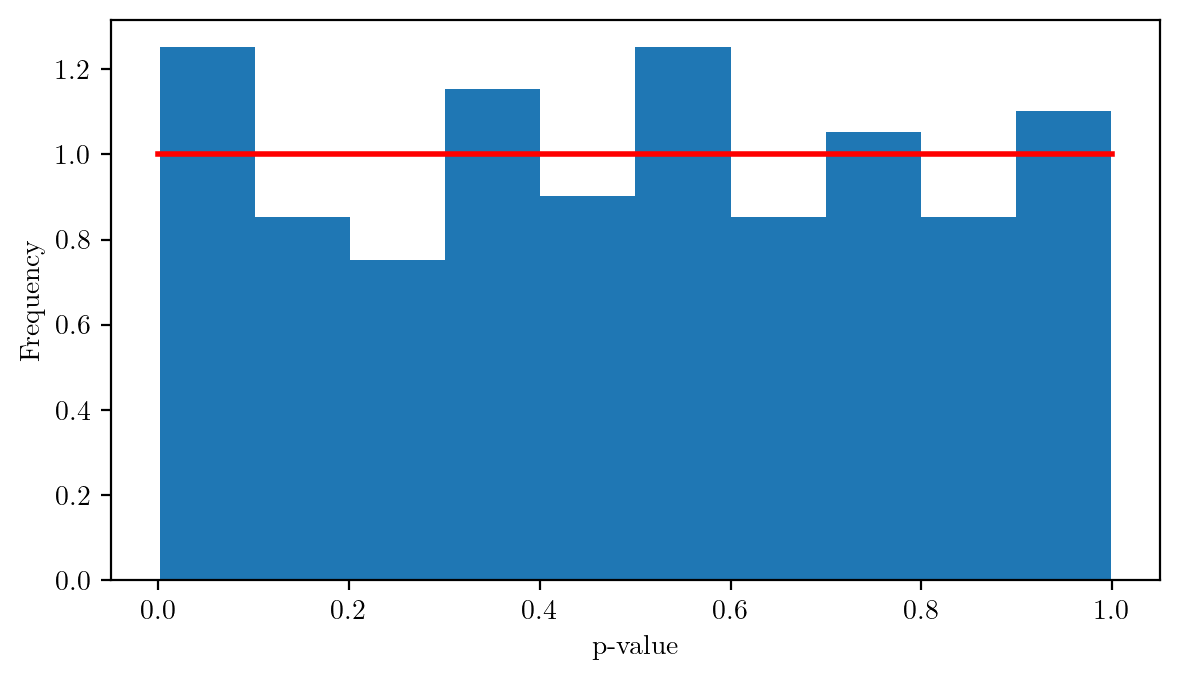

In [53]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.hist(p_val, bins=10, density=True)
# ax.plot(np.linspace(60, 160, 100), chi2.pdf(np.linspace(60, 160, 100), df=99), color='red')
ax.plot(np.linspace(0, 1, 100), uniform.pdf(np.linspace(0, 1, 100), loc=0, scale=1-0), 'r-', lw=2)

ax.set_xlabel('p-value')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [54]:
p_value_mean = []
p_value_std = []

gmm = GaussianMixtureModel(num_components=20, num_dims=100)


means = gmm.get_means()
variances = gmm.get_variances()
weights = gmm.get_weights()

for n_modes in range(10):
    gmm_short = GaussianMixtureModel(num_components=20 - n_modes, num_dims=100, means=means[n_modes:], variances=variances[n_modes:], weights=weights[n_modes:])
    p_val = []
    x_samples = gmm.generate_samples(num_samples=5000)
    y_samples = gmm_short.generate_samples(num_samples=5000)
    for i in range(20):
        pval = pqm_pvalue(x_samples, y_samples)
        p_val.append(pval)
    p_value_mean.append(np.mean(p_val))
    p_value_std.append(np.std(p_val))

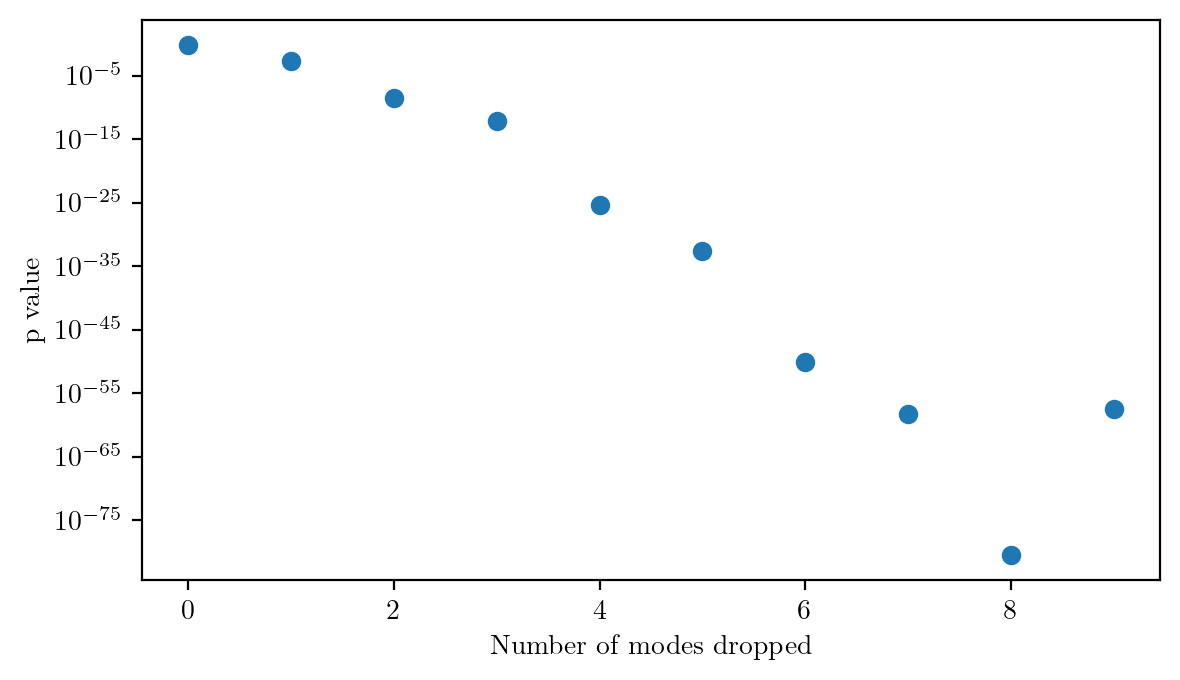

In [55]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(np.arange(10), p_value_mean, 'o')
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel(r'Number of modes dropped')
ax.set_ylabel('p value')  # Modified ylabel
ax.set_yscale('log')
plt.tight_layout()  # Increase the padding
plt.show()